dim_state:  3
dim_action:  1
space sample:  [-0.31874207  0.35473567 -4.6115456 ]
action sample:  [-0.19957659]


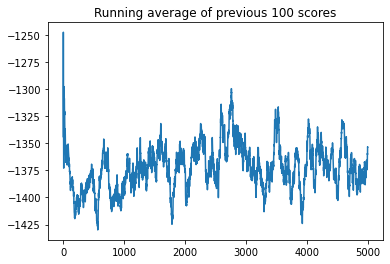

In [6]:
import torch as t
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as f
import numpy as np
import matplotlib.pyplot as plt
import gym
from torch.distributions.normal import Normal

###################################################
# Continuses Policy Gradient
###################################################

device = t.device('cuda' if t.cuda.is_available() else 'cpu')

class Actor(nn.Module):
    ###########################################################################
    # This is a generic actor function that outouts two arrays which can be used for 
    # Gaussian based continus actor(Mu,Sigma) for continues actions spaces
    ###########################################################################
    
    def __init__(self, dim_state, dim_action, alpha, checkpoint='actorGausi.pt', num_layers=2):
        super(Actor, self).__init__()
        self.alpha = alpha
        self.checkpoint = checkpoint
        layers = []
        for i in range(num_layers):
            layers.append(dim_state // 2**i)
        #print(layers)
        blocks=[self.block(i,j) for i, j in zip(layers[0:-1], layers[1:])]
        self.total_mc = nn.Sequential(*blocks)    

        self.linear_mu = nn.Linear(layers[-1], dim_action)
        self.linear_sigma = nn.Linear(layers[-1], dim_action)

        self.optimizer = optim.Adam(self.parameters(), lr = alpha, weight_decay=1e-4)
        self.device = t.device('cuda' if t.cuda.is_available() else 'cpu')
        self.to(self.device)
        self.repara = 1e-6
 
    def saveChk(self):
        print('save model...')
        t.save(self.state_dict(), self.checkpoint)

    def loadChk(self):
        print('load model')
        self.load_state_dict(t.load(self.checkpoint))

    def block(self, dim_in, dim_out):
        return nn.Sequential(
        nn.Linear(dim_in, dim_out),
        nn.ReLU()
        )

    def forward(self, x):
        output = x.to(self.device)
        output = self.total_mc(output)

        mu = self.linear_mu(output) #All thg mus
        sigma = self.linear_sigma(output) #All the sigmas

        sigma = t.clamp(sigma, min=self.repara, max=1)
        return mu, sigma

    def sample(self,state):
        state = state.to(self.device)
        mu, sigma = self.forward(state)
        nm = Normal(t.exp(mu), sigma)
        actions = nm.sample()

        log_probs = nm.log_prob(actions)

        return actions, log_probs
  
  
class Critic(nn.Module):   
    def __init__(self, dim_state, dim_action, fc1, fc2, alpha,checkpoint='critic'):
        super(Critic, self).__init__()
        self.dim_state = dim_state
        self.dim_action = dim_action
        self.path = checkpoint
        
        self.linear1 = nn.Linear(dim_state+ dim_action, fc1)
        self.linear2 = nn.Linear(fc1, fc2)
        self.linear3 = nn.Linear(fc2,1)
        self.optimizer = optim.Adam(self.parameters(), lr = alpha, weight_decay=1e-4)
        self.device = t.device('cuda' if t.cuda.is_available() else 'cpu')
        self.to(self.device)
        
    def forward(self, state, action):
        state = state.to(self.device)
        action = action.to(self.device)
        
        output = t.relu(self.linear1(t.cat((state, action), dim=1)))
        output = t.relu(self.linear2(output))
        output = self.linear3(output)
        
        return output
    
    def saveCheckpoint(self):
        print('...save checkout...')
        t.save(self.state_dict(), self.path)
    
    def loadCheckpoint(self):
        print ('...load checj point...')
        self.load_state_dict(t.load(self.path))
        
        
class replayBuffer():
    def __init__(self, maxm_size, dim_state, dim_action):
        self.counter = 0
        self.state_mem = np.zeros((maxm_size, dim_state))
        self.action_mem = np.zeros((maxm_size, dim_action))
        self.reward_mem = np.zeros(maxm_size)
        self.state_new_mem = np.zeros((maxm_size, dim_state))
        self.done_mem = np.zeros(maxm_size)
        self.maxm_size = maxm_size
        
    def store_Transaction(self, state, action, reward, state_new, done):
        index = self.counter % self.maxm_size
        
        self.state_mem[index] = state
        self.action_mem[index] = action
        self.reward_mem[index] = reward
        self.state_new_mem[index] =state_new
        self.done_mem[index] = 1.0 - done
        
        self.counter+=1
    
    def sample_batch(self, batch_size=126):
        maxm_size = min(self.counter, self.maxm_size)
        batch = np.random.choice(maxm_size, batch_size)
        
        state_batch = self.state_mem[batch]
        action_batch = self.action_mem[batch]
        reward_batch = self.reward_mem[batch]
        state_new_batch = self.state_new_mem[batch]
        done_batch = self.done_mem[batch]
        
        return state_batch, action_batch,reward_batch,state_new_batch,done_batch
        
    
class Agent():
    def __init__(self, env, dim_state, dim_action, fc1, fc2, alpha, gamma, maxm_size, maxm_iters=50, batch_size=126):
        self.dim_state = dim_state
        self.dim_action = dim_action
        self.maxm_iters = maxm_iters
        self.device = t.device('cuda' if t.cuda.is_available() else 'cpu')
        
        self.actor=Actor(dim_state, dim_action, alpha, checkpoint='actorGausi.pt', num_layers=2).to(self.device)
        self.critic=Critic(dim_state, dim_action, fc1, fc2, alpha,checkpoint='critic').to(self.device)
        self.tau = 1e-2
        self.alpha_entropy= 0.1
        
        #Initilize the target networks
        self.critic_t = self.critic.to(self.device)
        self.actor_t = self.actor.to(self.device)
        
        self.buffer = replayBuffer(maxm_size, dim_state, dim_action) # maxm_size, dim_state, dim_action):
        self.gamma = gamma
        self.batch_size = batch_size
        
        
    def plot_learning_curve(self,x, scores, figure_file='test'):
        running_avg = np.zeros(len(scores))
        for i in range(len(running_avg)):
            running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
        plt.plot(x, running_avg)
        plt.title('Running average of previous 100 scores')
        #plt.savefig(figure_file)
        
    def update_parms(self):
        
        critic_dict = dict(self.critic_t.named_parameters())
        critic_t_dict = dict(self.critic.named_parameters())
        
        actor_t_dict = dict(self.actor_t.named_parameters())
        actor_dict = dict(self.actor.named_parameters())
        
        #Update the critic
        for i in critic_dict:
            critic_dict[i] = self.tau*critic_dict[i].clone() + (1-self.tau)*critic_t_dict[i].clone()
        self.critic_t.load_state_dict(critic_dict)
        
        #Update the actor
        for j in actor_dict:
            actor_dict[j] = self.tau*actor_dict[j].clone() + (1-self.tau)*actor_t_dict[j].clone()
        self.actor_t.load_state_dict(actor_dict)
           
    def train(self):
        
        self.critic.train()
        self.actor.train()
        reward_list = [] 
        n_update = 0
           
        for i in range(self.maxm_iters):
            self.critic.zero_grad()
            self.actor.zero_grad()
            
            done= False
            state = env.reset()       
            total_reward= 0
            n_update+=1
            
            while not done:
                action,_ = self.actor.sample(t.tensor(state).float().to(self.device)) 
                state_new, reward, done, _ = env.step(action.cpu().detach().numpy())
                total_reward+=reward
        
                self.buffer.store_Transaction(state, action.cpu().detach().numpy(), reward, state_new, done)

                state_batch, action_batch, reward_batch, state_new_batch, done_batch = self.buffer.sample_batch()
                        
                ##Update the critic
                actions_next, log_probs_next = self.actor.sample(t.tensor(state_new_batch).float())
                
                with t.no_grad(): #Target treat as fixed value
                    target = t.tensor(reward_batch).to(self.device).view(-1,1)+self.gamma * self.critic(t.tensor(state_new_batch).float().to(self.device), \
                                                                                        actions_next.float()).to(self.device)*t.tensor(done_batch).to(self.device).view(-1,1)
                Qs = self.critic(t.tensor(state_batch).float(), t.tensor(action_batch).float())
        
                loss_critic = t.sum((target - Qs)**2)
        
                ##Update the actor
                _, log_probs = self.actor(t.tensor(state_batch).float())

                loss_actor = -log_probs * Qs
                loss_actor = loss_actor.mean(dim=0)

                loss = (loss_actor + loss_critic)
                loss.backward()
                self.actor.optimizer.step()
                self.critic.optimizer.step()
                    
                if n_update % 1000 ==0:
                    self.update_parms()
        
                state = state_new
            reward_list.append(total_reward)
        #print (reward_list)
        
        x = [i+1 for i in range(self.maxm_iters)]
        self.plot_learning_curve(x, reward_list)
        
if __name__ == '__main__':
    env = gym.make('Pendulum-v1')
    #env = or_gym.make('CartPoleSwingUp-v0')
    #env = gym.make('MountainCar-v0')
    dim_state = env.observation_space.shape[0]
    dim_action = env.action_space.shape[0]
    print('dim_state: ', dim_state)
    print ('dim_action: ', dim_action)
    print('space sample: ', env.observation_space.sample())
    print('action sample: ', env.action_space.sample())
    agent = Agent(env,dim_state,dim_action, 256, 256, 1e-5, 0.99, 3000, maxm_iters=5000)
    agent.train()